In [2]:
import numpy as np
import json
import random
import math
from time import time
from typing import List, Tuple, Dict
import matplotlib.pyplot as plt
import pandas as pd
%pip install folium
import folium

Note: you may need to restart the kernel to use updated packages.


In [3]:
# Load Files
distance_matrix = np.load('distance_matrix.npy')
print(f"Distance matrix shape: {distance_matrix.shape}")

with open('locations_mapping.json', 'r') as f:
    locations_mapping = json.load(f)

print(f"Number of locations: {len(locations_mapping)}")


print("\nExample distance:", distance_matrix[0][1])
print("\nExample location data:", locations_mapping['0'])

Distance matrix shape: (201, 201)
Number of locations: 201

Example distance: 26649.0

Example location data: {'latitude': 33.6424, 'longitude': -117.8417, 'address': 'UCI Warehouse: 2006 McGaw Ave, Irvine, CA 92614'}


In [19]:
locations_mapping_df

,latitude,longitude,address
0,33.642400,-117.841700,"UCI Warehouse: 2006 McGaw Ave, Irvine, CA 92614"
1,33.835846,-117.833145,"2003 E IVY HILL LN, ORANGE, California 92867"
2,33.879459,-117.694021,"5550 SHADY CREEK LN, YORBA LINDA, California 9..."
3,33.710949,-117.794305,"7 CONNECTICUT, IRVINE, California 92606"
4,33.698070,-117.986474,"8131 KINER AVE, HUNTINGTON BEACH, California 9..."
...,...,...,...
196,33.929139,-117.975070,"391 S OAKLAND DR, LA HABRA, California 90631"
197,33.604987,-117.890417,"112 ONYX AVE, NEWPORT BEACH, California 92662"
198,33.784306,-118.029914,"12262 SAINT MARK ST, GARDEN GROVE, California ..."
199,33.763427,-117.841236,"1919 N SHERRY LN Unit 63, SANTA ANA, Californi..."


In [4]:
def calculate_route_distance(route, distance_matrix):
    """Calculate total distance of a route including return to warehouse"""
    total_distance = 0
    for i in range(len(route) - 1):
        total_distance += distance_matrix[route[i]][route[i + 1]]
    # Add distance back to warehouse (index 0)
    total_distance += distance_matrix[route[-1]][0]
    return total_distance

def plot_route(route, locations_mapping, distance_matrix, title="TSP Route"):
    """Plot the route on a scatter plot"""
    plt.figure(figsize=(12, 8))
    
    # Extract coordinates using longitude and latitude
    x_coords = [locations_mapping[str(i)]['longitude'] for i in route]
    y_coords = [locations_mapping[str(i)]['latitude'] for i in route]
    
    # Add warehouse return coordinates
    x_coords.append(locations_mapping['0']['longitude'])
    y_coords.append(locations_mapping['0']['latitude'])
    
    # Plot points and routes
    plt.scatter(x_coords, y_coords, c='blue', s=50)
    plt.plot(x_coords, y_coords, 'r-', alpha=0.5)
    
    # Highlight warehouse
    plt.scatter([x_coords[0]], [y_coords[0]], c='red', s=100, label='Warehouse')
    
    # Add title and total distance
    total_distance = calculate_route_distance(route, distance_matrix)
    plt.title(f"{title}\nTotal Distance: {total_distance:.2f}")
    
    plt.legend()
    plt.grid(True)
    plt.show()



Test route: [0, 4, 2, 1, 3]
Test route distance: 110607.0


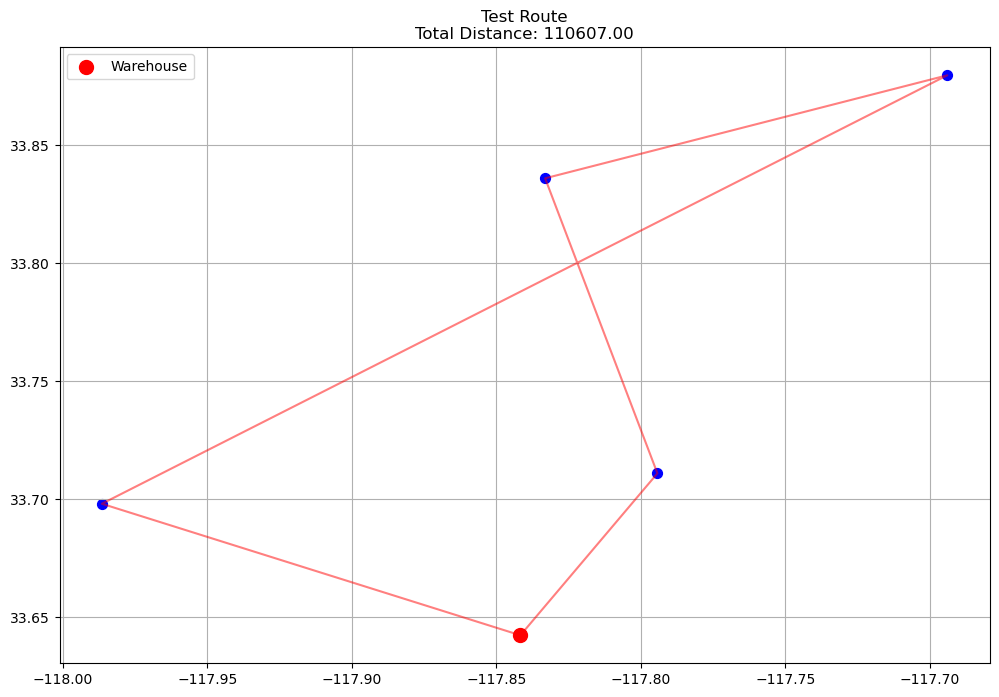

In [5]:
# Test the functions
test_route = [0] + random.sample(range(1, 5), 4)  # Small 5-location route
print("Test route:", test_route)
print("Test route distance:", calculate_route_distance(test_route, distance_matrix))
plot_route(test_route, locations_mapping, distance_matrix, "Test Route")

# Implement Algorithms

---

## Nearest Neighbor

In [ ]:
# locations_mapping_df=pd.DataFrame.from_dict(locations_mapping, orient='index')
# locations_mapping_df
# remaining_node = locations_mapping_df[1:] #Copy of Original Data Frame containing 200 addresses, except for warehouse start point
# # remaining_node
# visited_address = locations_mapping_df.iloc[:1] #insert warehouse location as first data point
# # visited_address.iloc[-1,1]
# current_longitude_coordinate, current_latitude_coordinate = visited_address.iloc[-1,1], visited_address.iloc[-1,0]
# current_longitude_coordinate, current_latitude_coordinate 
# next_longitude_coordinate, next_latitude_coordinate = remaining_node['longitude'], remaining_node['latitude']
# next_longitude_coordinate, next_latitude_coordinate      
# remaining_node["Distance"]=np.sqrt( (current_longitude_coordinate-next_longitude_coordinate)**2 + (current_latitude_coordinate-next_latitude_coordinate)**2)
# remaining_node
# next_address=remaining_node.sort_values(by='Distance')[:1].drop('Distance', axis=1)
# next_address

# visited_address=pd.concat([visited_address, next_address], ignore_index=True)
# visited_address

# remaining_node = remaining_node.iloc[1:] 
# remaining_node

# locations_mapping_df[:1]

/var/folders/4y/g2pgt5r957598fzxc2p9d0_80000gn/T/ipykernel_75585/867967042.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  remaining_node["Distance"]=np.sqrt( (current_longitude_coordinate-next_longitude_coordinate)**2 + (current_latitude_coordinate-next_latitude_coordinate)**2)


,latitude,longitude,address
0,33.6424,-117.8417,"UCI Warehouse: 2006 McGaw Ave, Irvine, CA 92614"


In [7]:
## DO NOT USE
# # def nearest_neighbor():
# #     """Implement Nearest Neighbor algorithm"""
# #     # TODO: Implement Nearest Neighbor algorithm
# #     # 1. Start from warehouse (index 0)
# #     # 2. Each time, find the nearest unvisited location
# #     # 3. Add it to the route
# #     # 4. Repeat until all locations are visited
# #     # 5. Return the route
# #     pass

# def nearest_neighbor(address_dict):
  
#   locations_mapping_df = pd.DataFrame.from_dict(address_dict, orient='index')

#   remaining_node = locations_mapping_df[1:].reset_index(drop=True)  #Copy of Original Data Frame containing 200 addresses, not including warehouse start point

#   visited_address = locations_mapping_df.iloc[:1].reset_index(drop=True) #insert warehouse location as first data point

#   while len(remaining_node)>0:
          
#           current_longitude_coordinate, current_latitude_coordinate = visited_address.iloc[-1,1], visited_address.iloc[-1,0]
#           next_longitude_coordinate, next_latitude_coordinate = remaining_node['longitude'], remaining_node['latitude']

#           remaining_node["Distance"]=np.sqrt( (current_longitude_coordinate-next_longitude_coordinate)**2 + (current_latitude_coordinate-next_latitude_coordinate)**2)
#           next_address=remaining_node.sort_values(by='Distance')[:1].drop('Distance', axis=1)

#           visited_address=pd.concat([visited_address, next_address], ignore_index=True)
#           remaining_node = remaining_node.iloc[1:].reset_index(drop=True) #Removed visited node from 'remaining_node' dataframe

#   visited_address=pd.concat([visited_address,locations_mapping_df[:1]], ignore_index=True) #insert warehouse location as the last visited address#insert warehouse location as the last visited address

#   #total_distance = calculate_route_distance(visited_address,distance_matrix) # Use API to calculate travelled distance based on the order of visited_address

#   return visited_address

In [112]:
##OK
def nearest_neighbor(address_dict):
    # Convert the dictionary to a DataFrame titled 'locations_mapping_df'
    locations_mapping_df = pd.DataFrame.from_dict(address_dict, orient='index').reset_index(drop=True)

    # Create 2 dataframes: remaining_node includes addresses without the starting point (UCI Warehouse); visited_address will append order of address visited starting from UCI Warehouse
    remaining_node = locations_mapping_df.iloc[1:].reset_index(drop=True)  # Exclude the first row
    visited_address = locations_mapping_df.iloc[:1].reset_index(drop=True)  # Include only the first row

    while not remaining_node.empty: 
        # Get the coordinates of the last visited location
        current_longitude_coordinate = visited_address.iloc[-1]['longitude']
        current_latitude_coordinate = visited_address.iloc[-1]['latitude']

        # Calculate distances to all remaining nodes
        remaining_node = remaining_node.assign(
            Distance=np.sqrt(
                (current_longitude_coordinate - remaining_node["longitude"]) ** 2 +
                (current_latitude_coordinate - remaining_node["latitude"]) ** 2
            )
        )

        # Find the next address (row with the minimum distance)
        next_address = remaining_node.loc[remaining_node["Distance"].idxmin()]

        # Append the next address to the visited_address dataframe
        visited_address = pd.concat(
            [visited_address, pd.DataFrame([next_address], columns=remaining_node.columns)],
            ignore_index=True
        )

        # Remove the visited node from remaining nodes
        remaining_node = remaining_node.drop(remaining_node["Distance"].idxmin()).reset_index(drop=True)

    # Return to the start location
    visited_address = pd.concat([visited_address, locations_mapping_df.iloc[:1]], ignore_index=True)
    visited_address['number'] = visited_address['address'].map(locations_mapping_df.reset_index().set_index('address')['index'])
    nn_route = visited_address.loc[:,'number']

    # Calculate total distance 
    #total_distance = calculate_route_distance(visited_address.loc[:,'number'].to_list(), distance_matrix) 

    return np.array(nn_route)

In [ ]:
#TEST


Nearest Neighbor Results:
Time taken: 1.45 seconds
Route length: 201
Total distance: 952123.00


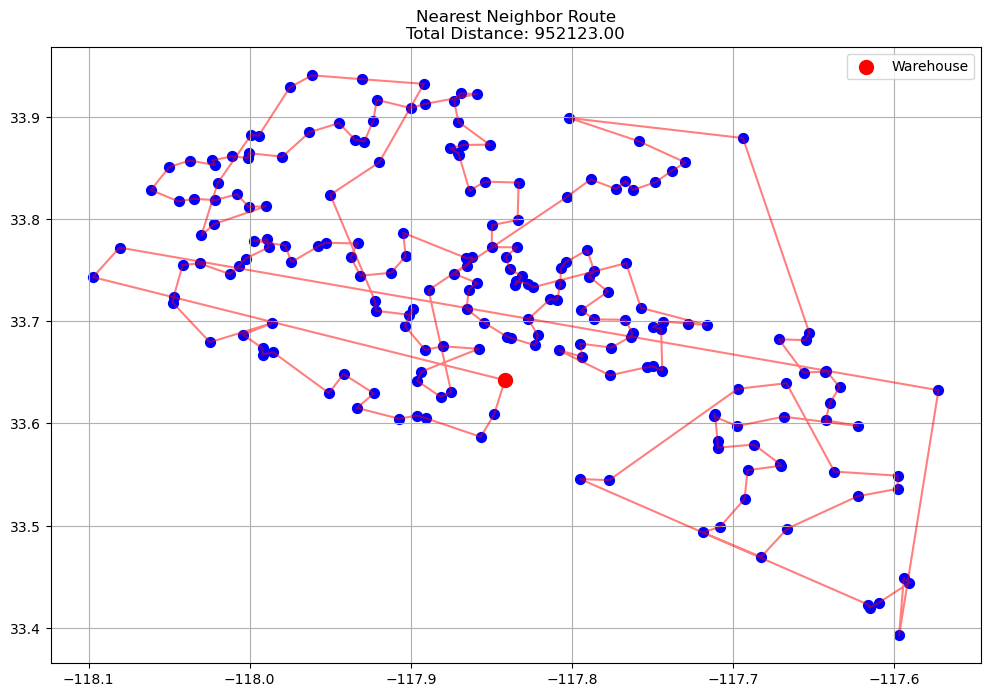

In [113]:
# Testing nearest neighbor
try:
    start_time = time()
    nn_route = nearest_neighbor(locations_mapping)
    end_time = time()
    
    print("\nNearest Neighbor Results:")
    print(f"Time taken: {end_time - start_time:.2f} seconds")
    print(f"Route length: {len(nn_route)-1}")
    print(f"Total distance: {calculate_route_distance(nn_route, distance_matrix):.2f}")
    
    plot_route(nn_route,locations_mapping, distance_matrix, "Nearest Neighbor Route")
except:
    print("Error: Nearest Neighbor algorithm not implemented yet")


In [115]:
def plotted_map(best_route):
  warehouse_start_point = [33.642400,-117.8417]
  map=folium.Map(location=warehouse_start_point, zoom_start=10.49,tiles="Cartodb Positron")
  folium.Marker(warehouse_start_point, popup="UCI Warehouse, 2006 McGaw Ave, Irvine, CA 92614", icon=folium.Icon(color="blue", icon="star")).add_to(map)

  locations_mapping_df_reset = locations_mapping_df.reset_index(drop=True)
  locations_mapping_df_reordered = locations_mapping_df_reset.loc[best_route].reset_index(drop=True)

  
  for i in range(len(locations_mapping_df_reordered) - 1):
    long1, lat1 = locations_mapping_df_reordered.loc[i,'longitude'], locations_mapping_df_reordered.loc[i,'latitude']
    long2, lat2 = locations_mapping_df_reordered.loc[i+1,'longitude'], locations_mapping_df_reordered.loc[i+1,'latitude']

    folium.CircleMarker([lat1, long1], radius=3, fill=False, fill_opacity=.1 ,color='blue', popup=i).add_to(map)
    folium.PolyLine([[lat1, long1],[lat2,long2]], color = "red").add_to(map)

  
  return map


plotted_map(nearest_neighbor(locations_mapping))

## Simulated Annealing

In [12]:
def simulated_annealing(initial_temp=100.0, cooling_rate=0.995, iterations=10000):
    """Implement Simulated Annealing algorithm"""
    # TODO: Implement Simulated Annealing algorithm
    # 1. Generate initial random solution
    # 2. For each iteration:
    #    - Generate neighbor solution by swapping two cities
    #    - Calculate new distance
    #    - Accept if better
    #    - Accept with probability if worse
    #    - Update temperature
    # 3. Return best route found
    pass


In [13]:

# Test Simulated Annealing
try:
    start_time = time()
    sa_route = simulated_annealing()
    end_time = time()
    
    print("\nSimulated Annealing Results:")
    print(f"Time taken: {end_time - start_time:.2f} seconds")
    print(f"Route length: {len(sa_route)}")
    print(f"Total distance: {calculate_route_distance(sa_route):.2f}")
    
    plot_route(sa_route, "Simulated Annealing Route")
except:
    print("Error: Simulated Annealing algorithm not implemented yet")



Simulated Annealing Results:
Time taken: 0.00 seconds
Error: Simulated Annealing algorithm not implemented yet


## Random Search (Base case)

In [14]:
# Change it to 10000 later
def random_search(n_samples=100):
    """Implement Random Search algorithm"""
    best_route = None
    best_distance = float('inf')  # Initialize with infinity
    
    # Get number of locations (excluding warehouse)
    n_locations = len(distance_matrix)
    
    for _ in range(n_samples):
        # Generate random route (keeping warehouse as start)
        current_route = [0] + random.sample(range(1, n_locations), n_locations-1)
        
        # Calculate total distance
        current_distance = calculate_route_distance(current_route, distance_matrix)
        
        # Update best route if current route is better
        if current_distance < best_distance:
            best_distance = current_distance
            best_route = current_route
    
    return best_route




Random Search Results:
Time taken: 0.05 seconds
Route length: 201
Total distance: 5325054.00


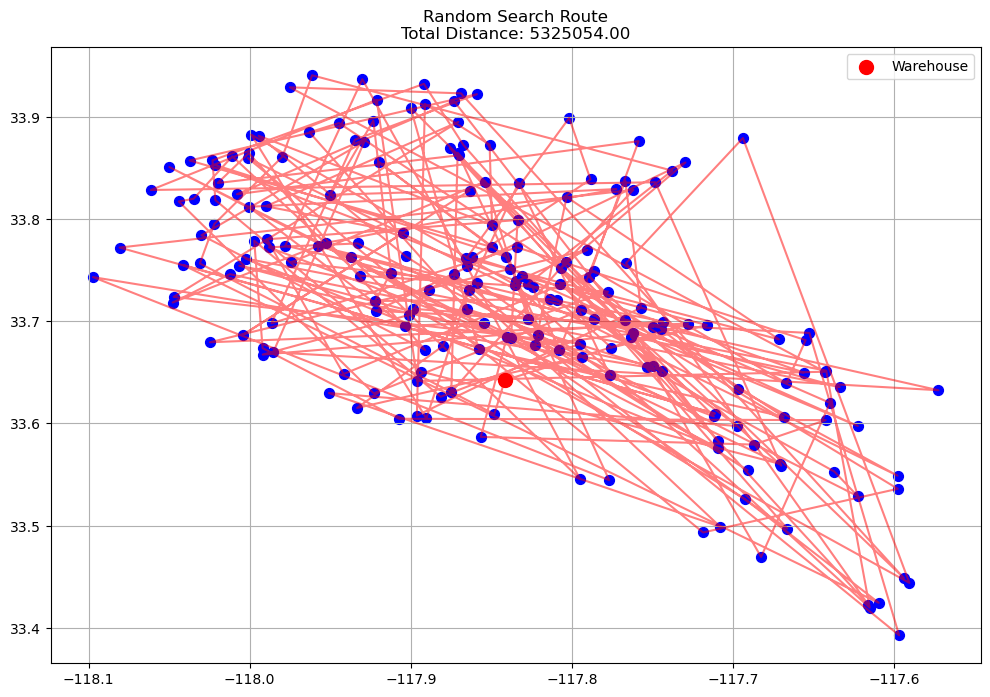

In [15]:
# Test Random Search
try:
    start_time = time()
    random_route = random_search()
    end_time = time()
    
    print("\nRandom Search Results:")
    print(f"Time taken: {end_time - start_time:.2f} seconds")
    print(f"Route length: {len(random_route)}")
    print(f"Total distance: {calculate_route_distance(random_route, distance_matrix):.2f}")
    
    plot_route(random_route, locations_mapping, distance_matrix, "Random Search Route")
except Exception as e:
    print(f"Error in Random Search: {str(e)}")

### Maybe add solution case for google map tsp solution api as a metric?

---


In [16]:
# Only run this after implementing all algorithms
def compare_all_results():
    print("\nComparing All Algorithms:")
    
    try:
        # Run Nearest Neighbor
        start_time = time()
        nn_route = nearest_neighbor()
        nn_time = time() - start_time
        nn_distance = calculate_route_distance(nn_route)
        print(f"\nNearest Neighbor:")
        print(f"Distance: {nn_distance:.2f}")
        print(f"Time: {nn_time:.2f} seconds")
        plot_route(nn_route, "Nearest Neighbor Route")
    except:
        print("Nearest Neighbor not implemented")
    
    try:
        # Run Simulated Annealing
        start_time = time()
        sa_route = simulated_annealing()
        sa_time = time() - start_time
        sa_distance = calculate_route_distance(sa_route)
        print(f"\nSimulated Annealing:")
        print(f"Distance: {sa_distance:.2f}")
        print(f"Time: {sa_time:.2f} seconds")
        plot_route(sa_route, "Simulated Annealing Route")
    except:
        print("Simulated Annealing not implemented")
    
    try:
        # Run Random Search
        start_time = time()
        random_route = random_search()
        random_time = time() - start_time
        random_distance = calculate_route_distance(random_route)
        print(f"\nRandom Search:")
        print(f"Distance: {random_distance:.2f}")
        print(f"Time: {random_time:.2f} seconds")
        plot_route(random_route, "Random Search Route")
    except:
        print("Random Search not implemented")

# Uncomment to run comparison after implementing all algorithms
# compare_all_results()